In [1]:
import os
import cv2
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [2]:
import os
from zipfile import ZipFile


!pip install kaggle


os.environ['KAGGLE_USERNAME'] = "majisouvik1099"
os.environ['KAGGLE_KEY'] = "9464225218d56f8bfea9dd9cc437489f"


!kaggle datasets download -d jessicali9530/lfw-dataset


with ZipFile('lfw-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('lfw-dataset')


os.remove('lfw-dataset.zip')


 97% 109M/112M [00:01<00:00, 89.9MB/s] 
100% 112M/112M [00:01<00:00, 77.1MB/s]


In [3]:

def extract_features(image_path, model):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    image = image.unsqueeze(0)
    with torch.no_grad():
        features = model(image)
    features = features.squeeze(0)
    return features


def compute_hog(img):
    resized_img = resize(img, (128*4, 64*4))
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
    return fd


def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))
    val_ar.append(get_pixel(img, center, x, y+1))
    val_ar.append(get_pixel(img, center, x+1, y+1))
    val_ar.append(get_pixel(img, center, x+1, y))
    val_ar.append(get_pixel(img, center, x+1, y-1))
    val_ar.append(get_pixel(img, center, x, y-1))
    val_ar.append(get_pixel(img, center, x-1, y-1))
    val_ar.append(get_pixel(img, center, x-1, y))

    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val

def calcLBP(img):
    height, width, channel = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_lbp = np.zeros((height, width,3), np.uint8)
    for i in range(0, height):
        for j in range(0, width):
             img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
    hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
    return hist_lbp.flatten()


In [4]:
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 111MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [5]:
lfw_folder = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
X, y = [], []
for folder_name in os.listdir(lfw_folder):
    folder_path = os.path.join(lfw_folder, folder_name)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        if num_images > 70:
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = imread(image_path)
                # hog_feature = compute_hog(image)
                lbp_feature = calcLBP(image)
                # cnn_feature = extract_features(image_path, resnet).numpy()
                # hog_feature = hog_feature.reshape(-1)
                lbp_feature = lbp_feature.reshape(-1)
                # cnn_feature = cnn_feature.flatten()
                # combined_feature = np.concatenate((hog_feature, lbp_feature, cnn_feature))

                X.append(lbp_feature)
                y.append(folder_name)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [7]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [8]:
mlp_clf = MLPClassifier()
mlp_clf.fit(X_train, y_train_encoded)
y_pred_mlp = mlp_clf.predict(X_test)
accuracy_mlp = accuracy_score(y_test_encoded, y_pred_mlp)
print("MLP Classifier")
print("Accuracy:", accuracy_mlp)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_mlp, target_names=label_encoder.classes_))

MLP Classifier
Accuracy: 0.3798449612403101
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.40      0.14      0.21        14
     Colin_Powell       0.33      0.40      0.36        40
  Donald_Rumsfeld       0.43      0.09      0.15        34
    George_W_Bush       0.54      0.61      0.58       109
Gerhard_Schroeder       0.14      0.35      0.20        23
      Hugo_Chavez       0.00      0.00      0.00        11
       Tony_Blair       0.18      0.07      0.11        27

         accuracy                           0.38       258
        macro avg       0.29      0.24      0.23       258
     weighted avg       0.39      0.38      0.36       258



In [9]:
y_pred_mlp = mlp_clf.predict(X_train)
accuracy_mlp = accuracy_score(y_train_encoded, y_pred_mlp)
print("MLP Classifier")
print(" Training Accuracy:", accuracy_mlp)

MLP Classifier
 Training Accuracy: 0.5106796116504855


In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}


grid_search = GridSearchCV(MLPClassifier(), param_grid, cv=3, n_jobs=-1)


grid_search.fit(X_train, y_train_encoded)


best_mlp_clf = grid_search.best_estimator_


y_pred_mlp = best_mlp_clf.predict(X_test)

accuracy_mlp = accuracy_score(y_test_encoded, y_pred_mlp)

print("MLP Classifier")
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_mlp)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_mlp, target_names=label_encoder.classes_))


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


MLP Classifier
Best Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
Accuracy: 0.43410852713178294
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        14
     Colin_Powell       0.54      0.17      0.26        40
  Donald_Rumsfeld       1.00      0.03      0.06        34
    George_W_Bush       0.43      0.95      0.59       109
Gerhard_Schroeder       0.00      0.00      0.00        23
      Hugo_Chavez       0.00      0.00      0.00        11
       Tony_Blair       0.00      0.00      0.00        27

         accuracy                           0.43       258
        macro avg       0.28      0.17      0.13       258
     weighted avg       0.40      0.43      0.30       258



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
mlp_clf = MLPClassifier(
    activation='tanh',
    alpha=0.0001,
    hidden_layer_sizes=(50,),
    learning_rate='constant',
    solver='adam',
    max_iter=500
)
mlp_clf.fit(X_train, y_train_encoded)
y_pred_mlp = mlp_clf.predict(X_test)
accuracy_mlp = accuracy_score(y_test_encoded, y_pred_mlp)
print("MLP Classifier")
print("Accuracy:", accuracy_mlp)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_mlp, target_names=label_encoder.classes_))

MLP Classifier
Accuracy: 0.4108527131782946
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        14
     Colin_Powell       0.36      0.23      0.28        40
  Donald_Rumsfeld       0.00      0.00      0.00        34
    George_W_Bush       0.42      0.89      0.57       109
Gerhard_Schroeder       0.00      0.00      0.00        23
      Hugo_Chavez       0.00      0.00      0.00        11
       Tony_Blair       0.00      0.00      0.00        27

         accuracy                           0.41       258
        macro avg       0.11      0.16      0.12       258
     weighted avg       0.23      0.41      0.28       258



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
y_pred_mlp = mlp_clf.predict(X_train)
accuracy_mlp = accuracy_score(y_train_encoded, y_pred_mlp)
print("MLP Classifier")
print(" Training Accuracy:", accuracy_mlp)

MLP Classifier
 Training Accuracy: 0.41941747572815535


In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=None)
X_train_lda = lda.fit_transform(X_train, y_train_encoded)
X_test_lda = lda.transform(X_test)

In [15]:
# mlp_clf = MLPClassifier(max_iter=500)
mlp_clf.fit(X_train_pca, y_train_encoded)
y_pred_mlp = mlp_clf.predict(X_test_pca)
accuracy_mlp = accuracy_score(y_test_encoded, y_pred_mlp)
print("MLP Classifier")
print("Accuracy:", accuracy_mlp)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_mlp, target_names=label_encoder.classes_))

MLP Classifier
Accuracy: 0.3875968992248062
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        14
     Colin_Powell       0.29      0.45      0.35        40
  Donald_Rumsfeld       0.20      0.06      0.09        34
    George_W_Bush       0.45      0.73      0.56       109
Gerhard_Schroeder       0.00      0.00      0.00        23
      Hugo_Chavez       0.00      0.00      0.00        11
       Tony_Blair       0.00      0.00      0.00        27

         accuracy                           0.39       258
        macro avg       0.13      0.18      0.14       258
     weighted avg       0.26      0.39      0.30       258



In [16]:
y_pred_mlp = mlp_clf.predict(X_train_pca)
accuracy_mlp = accuracy_score(y_train_encoded, y_pred_mlp)
print("MLP Classifier")
print("Accuracy:", accuracy_mlp)

MLP Classifier
Accuracy: 0.4601941747572815


In [20]:
# mlp_clf = MLPClassifier(max_iter=500)
mlp_clf.fit(X_train_lda, y_train_encoded)
y_pred_mlp = mlp_clf.predict(X_test_lda)
accuracy_mlp = accuracy_score(y_test_encoded, y_pred_mlp)
print("MLP Classifier")
print("Accuracy:", accuracy_mlp)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_mlp, target_names=label_encoder.classes_))

MLP Classifier
Accuracy: 0.3992248062015504
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.29      0.29      0.29        14
     Colin_Powell       0.36      0.50      0.42        40
  Donald_Rumsfeld       0.25      0.15      0.19        34
    George_W_Bush       0.60      0.59      0.60       109
Gerhard_Schroeder       0.33      0.17      0.23        23
      Hugo_Chavez       0.09      0.09      0.09        11
       Tony_Blair       0.13      0.19      0.15        27

         accuracy                           0.40       258
        macro avg       0.29      0.28      0.28       258
     weighted avg       0.41      0.40      0.40       258



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:
y_pred_mlp = mlp_clf.predict(X_train_lda)
accuracy_mlp = accuracy_score(y_train_encoded, y_pred_mlp)
print("MLP Classifier")
print("Accuracy:", accuracy_mlp)

MLP Classifier
Accuracy: 0.7990291262135922


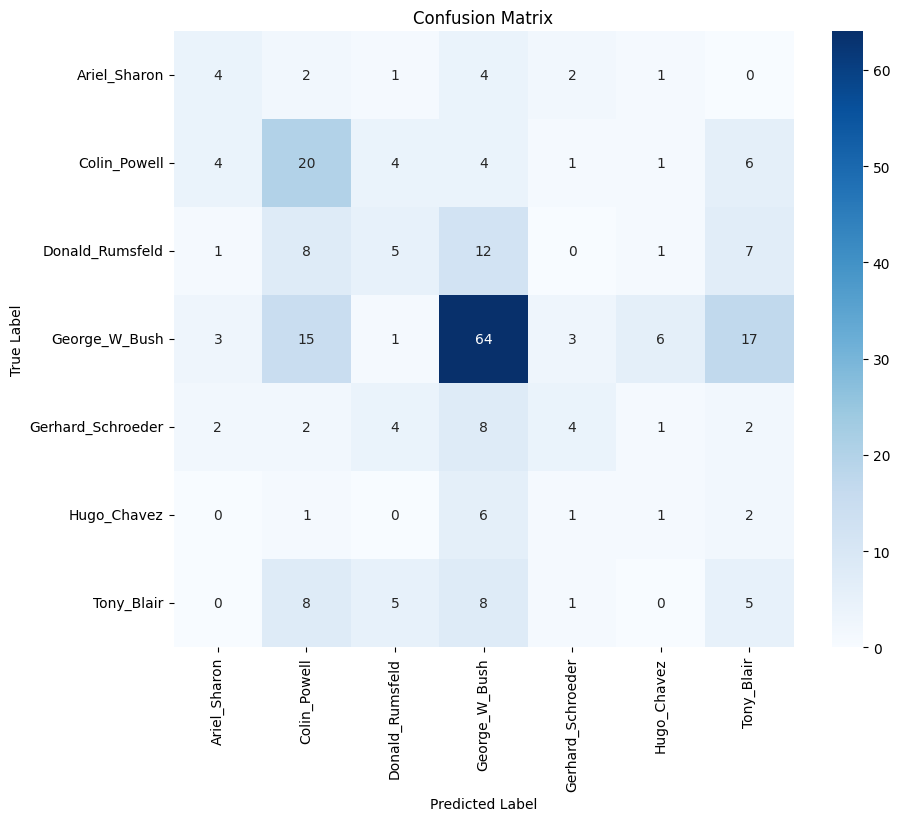

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_mlp)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
